<a href="https://colab.research.google.com/github/sinitsky96/Time-Series-Project/blob/main/prophet_checks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving co_half_monthly.csv to co_half_monthly.csv


In [ ]:
co = pd.read_csv('co_half_monthly.csv', parse_dates=['date'])
co.set_index('date', inplace=True)
co = co[co.index >= '2012-01-01']

co_avg = (co.groupby(co.index)["CO"]
          .mean()
          .reset_index()
          .set_index('date'))

daily_co = pd.read_csv('co_clean.csv', parse_dates=['date_time'])
daily_co.set_index('date_time', inplace=True)
daily_co = daily_co[daily_co.index >= '2012-01-01']

daily_co_avg = (daily_co.groupby(daily_co.index)["co"]
      .mean()
      .reset_index()
      .set_index('date_time'))

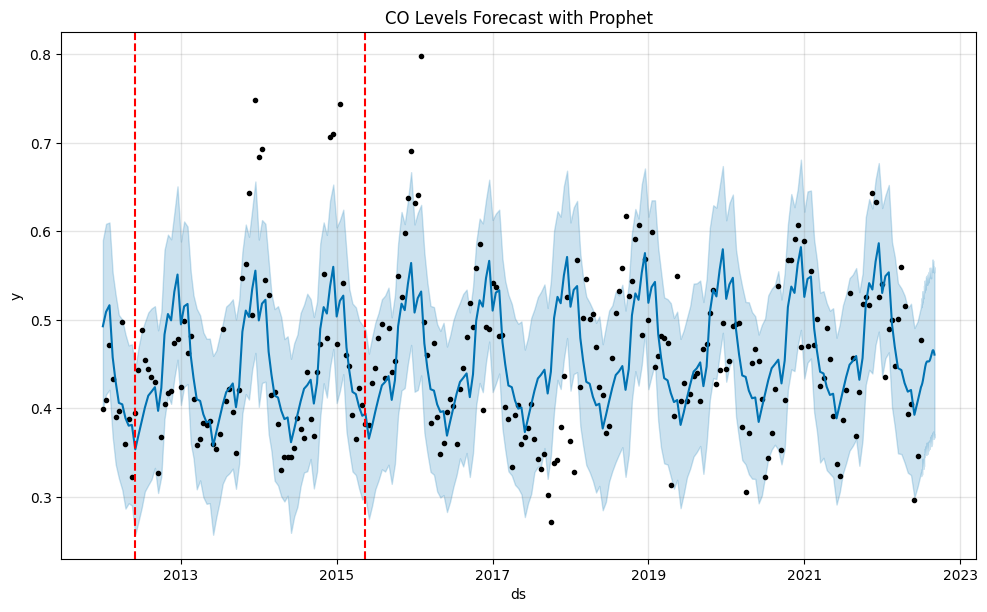

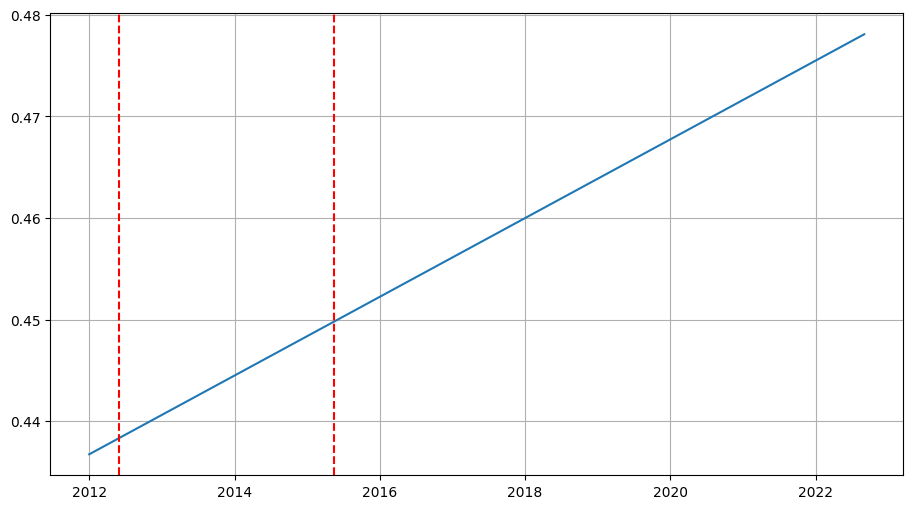

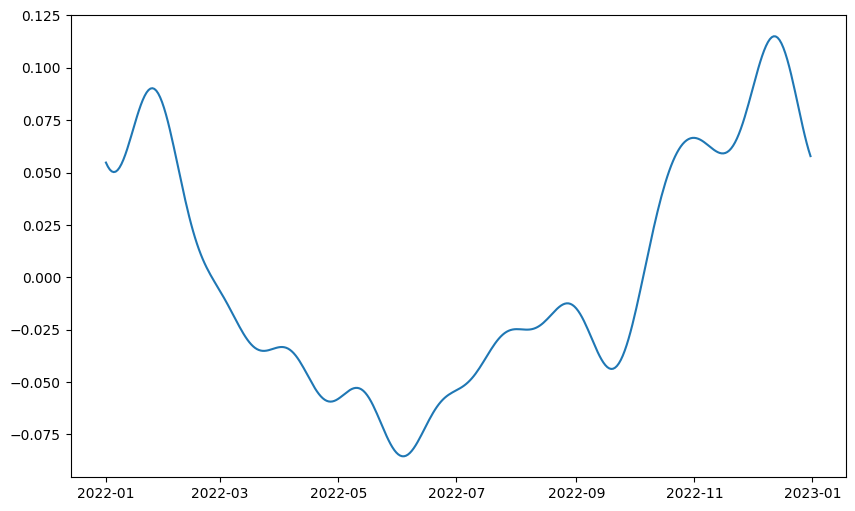

In [ ]:
apply_prophet(co_avg, 2)

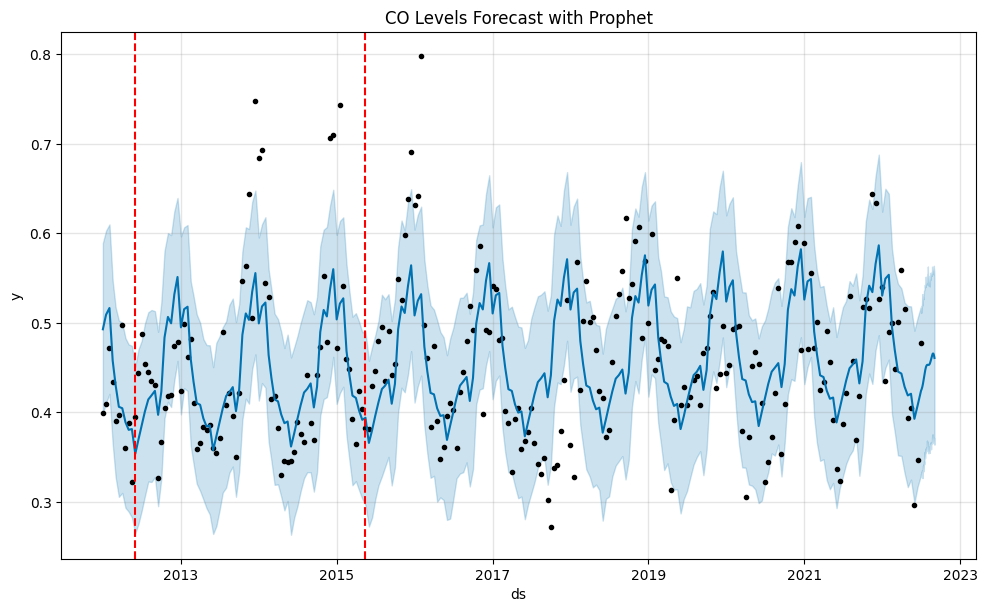

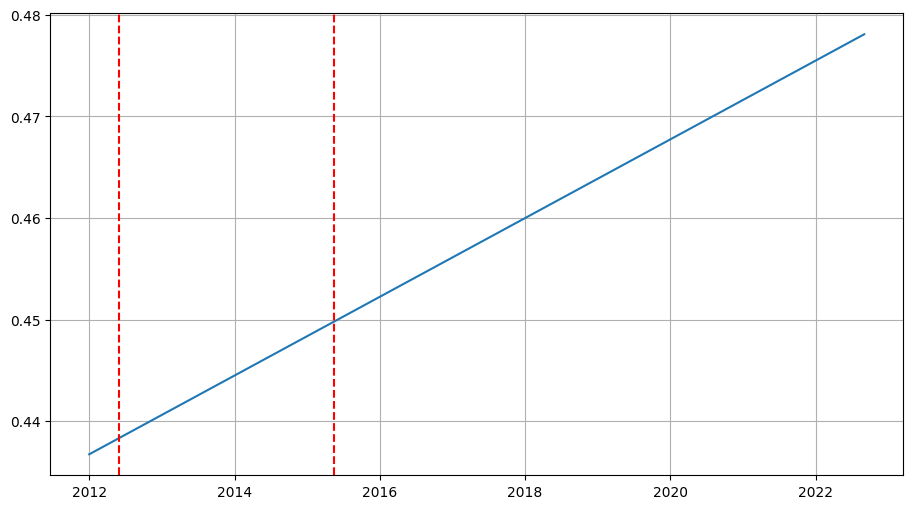

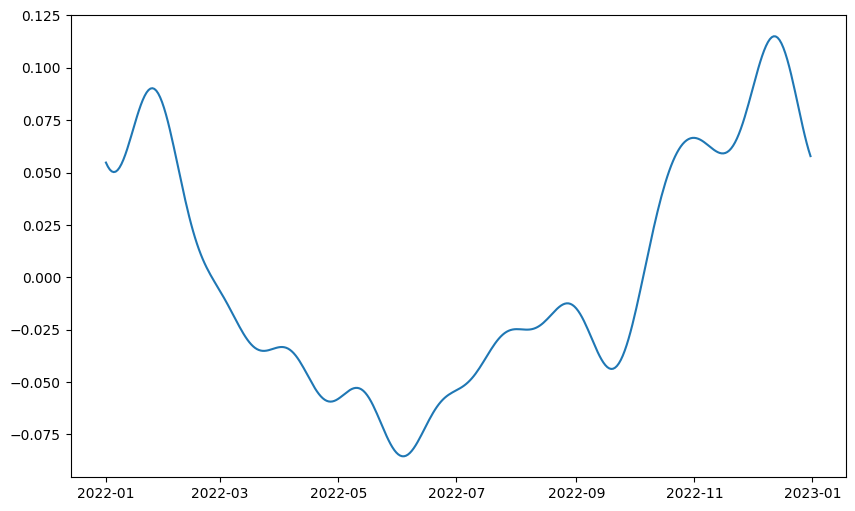

In [ ]:
apply_prophet(daily_co_avg, 2)

In [ ]:
def apply_prophet(data, top_n, weekly=False):
  """
  Apply Prophet model to the training data and forecast for the test data.
  data - dataset to fit
  top_n - number of top changepoints to use
  weekly - whether to use weekly seasonality
  """

  #split to train and test
  train_size = int(len(co_avg) * 0.8)
  train = co_avg.iloc[:train_size]
  test = co_avg.iloc[train_size:]

  prophet_df = train.reset_index()
  prophet_df.columns = ['ds', 'y']

  model_prophet = Prophet(yearly_seasonality=True,
                          weekly_seasonality=weekly,
                          daily_seasonality=False,
                          changepoint_prior_scale=0.01,
                        changepoint_range=1.0)
  model_prophet.fit(prophet_df)

  changpoints= pd.DataFrame({"cp": model_prophet.changepoints,
             "deltas" : np.abs(model_prophet.params['delta'])[0]
             })

  top_cp = changpoints.sort_values(by='deltas',
                                   ascending=False).head(top_n)['cp']

  # Forecast for a number of periods equal to the length of the test set
  future_dates = model_prophet.make_future_dataframe(periods=len(test))
  forecast_prophet = model_prophet.predict(future_dates)

  prophet_fitted = (forecast_prophet
                    .loc[forecast_prophet['ds']
                         .isin(prophet_df['ds']), 'yhat'])
  prophet_actual = prophet_df['y']

  prophet_metrics = {
    'RMSE': np.sqrt(mean_squared_error(prophet_actual, prophet_fitted)),
    'MAE': mean_absolute_error(prophet_actual, prophet_fitted)
  }

  fig1 = model_prophet.plot(forecast_prophet)
  for cp in top_cp:
      plt.axvline(x=cp, color='r', linestyle='--')
  plt.title('CO Levels Forecast with Prophet')
  plt.show()

  plt.figure(figsize=(11, 6))
  plt.plot(forecast_prophet['ds'], forecast_prophet['trend'])
  for cp in top_cp:
      plt.axvline(x=cp, color='r', linestyle='--')
  plt.grid()
  plt.show()

  dates = pd.date_range(start='2022-01-01', end='2022-12-31')
  df_dates = pd.DataFrame({'ds': dates})
  seasonal_component = model_prophet.predict_seasonal_components(df_dates)
  plt.figure(figsize=(10, 6))
  plt.plot(dates, seasonal_component['yearly'])
  plt.show()

In [ ]:
# find best prior scale with cross validation

train_size = int(len(co_avg) * 0.8)
train = co_avg.iloc[:train_size]
test = co_avg.iloc[train_size:]

# Convert the training data to Prophet format
prophet_df = train.reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires these specific column names

#  Define a Range of changepoint_prior_scale Values to Compare
cps_values = [0.001, 0.01, 0.05, 0.1, 0.5]

# Collect performance metrics for each CPS value
all_perf = []

for cps in cps_values:
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        changepoint_range=1.0
    )
    model.fit(prophet_df)

    # Cross-Validation Setup
    df_cv = cross_validation(
        model=model,
        initial='1460 days',  # ~4 years
        period='180 days',    # ~6 months
        horizon='365 days',   # ~1 year forecast
        parallel='processes'  # speeds up CV if you have multiple CPUs
    )

   # Compute Performance Metrics
    df_perf = performance_metrics(df_cv)
    df_perf['changepoint_prior_scale'] = cps

    all_perf.append(df_perf)

INFO:prophet:Making 12 forecasts with cutoffs between 2016-01-29 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df59e3c54d0>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-01-29 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df597075e50>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-01-29 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df597142fd0>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-01-29 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df59dfa09d0>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-01-29 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures

In [ ]:
results_df.groupby('changepoint_prior_scale', as_index=False).mean()

,changepoint_prior_scale,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0.001,203 days 17:05:27.272727272,0.009403,0.096395,0.076131,0.180586,0.139311,0.163809,0.667118
1,0.010,203 days 17:05:27.272727272,0.008318,0.090788,0.072559,0.168941,0.132665,0.158207,0.677399
2,0.050,203 days 17:05:27.272727272,0.010913,0.103789,0.081709,0.185119,0.149562,0.183438,0.609488
3,0.100,203 days 17:05:27.272727272,0.012490,0.110912,0.086100,0.191803,0.162470,0.196457,0.579275
4,0.500,203 days 17:05:27.272727272,0.021009,0.142422,0.108296,0.237027,0.201076,0.259295,0.486201


In [ ]:
models = []
forecasts = []
for station in co.station.unique():
  df = co.loc[co['station'] == station].drop(['station'], axis = 1)
  train_size = int(len(df) * 0.8)
  train = df.iloc[:train_size]
  test = df.iloc[train_size:]

  prophet_df = train.reset_index()
  prophet_df.columns = ['ds', 'y']

  # Fit Prophet model on training data
  model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False,
                          daily_seasonality=False, changepoint_prior_scale=0.05,
                        changepoint_range=1.0)
  model_prophet.fit(prophet_df)

  models.append(model_prophet)

  # Forecast for a number of periods equal to the length of the test set
  future_dates = model_prophet.make_future_dataframe(periods=len(test))
  forecast_prophet = model_prophet.predict(future_dates)
  forecasts.append(forecast_prophet)

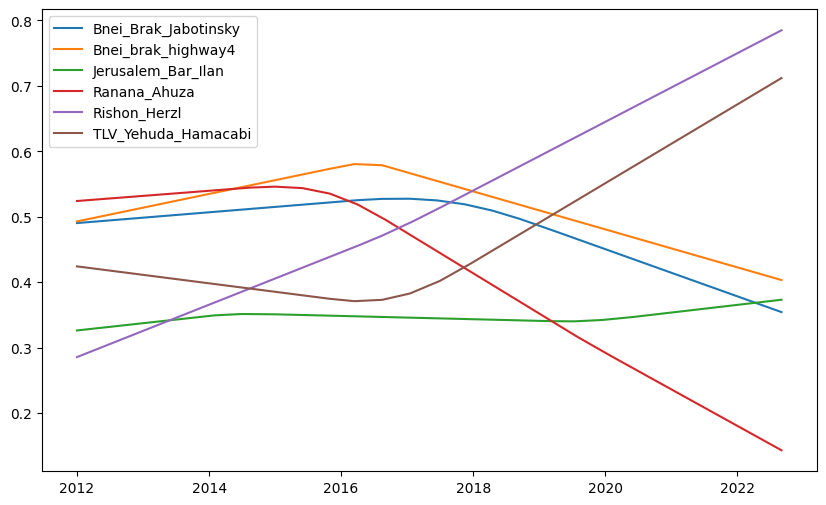

In [ ]:
plt.figure(figsize=(10, 6))
# prophet for each station:
for i in range(len(forecasts)):
  plt.plot(forecasts[i]['ds'], forecasts[i]['trend'],
           label=co.station.unique()[i])

plt.legend()

In [ ]:
future = pd.date_range(start='2022-01-01', end='2022-12-31')
df_future = pd.DataFrame({'ds': future})

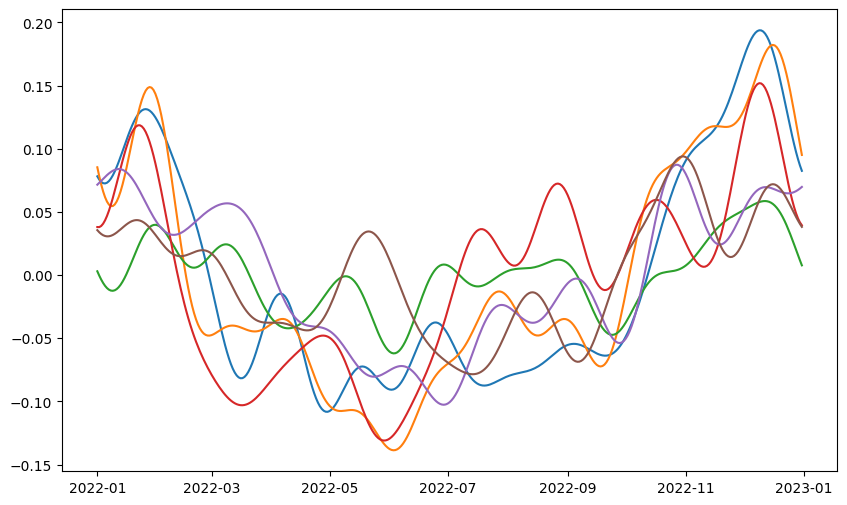

In [ ]:
plt.figure(figsize=(10, 6))
# prophet for each station:
for i in range(len(forecasts)):
  seasonal = models[i].predict_seasonal_components(df_future)
  plt.plot(df_future['ds'], seasonal['yearly'],
           label=co.station.unique()[i])


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving co_clean.csv to co_clean.csv


In [ ]:
train_size = int(len(daily_co_avg) * 0.8)
train = daily_co_avg.iloc[:train_size]
test = daily_co_avg.iloc[train_size:]

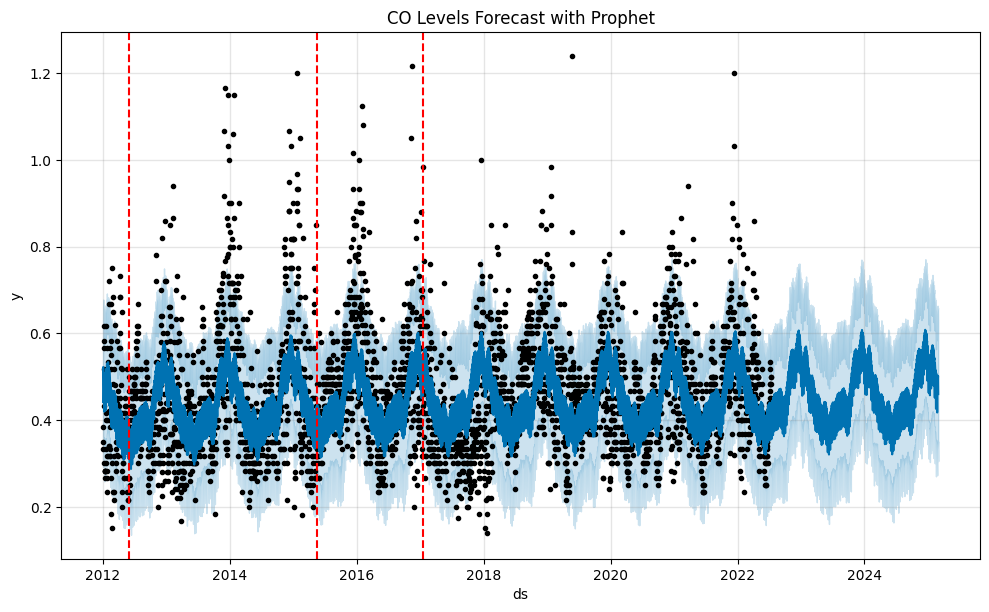

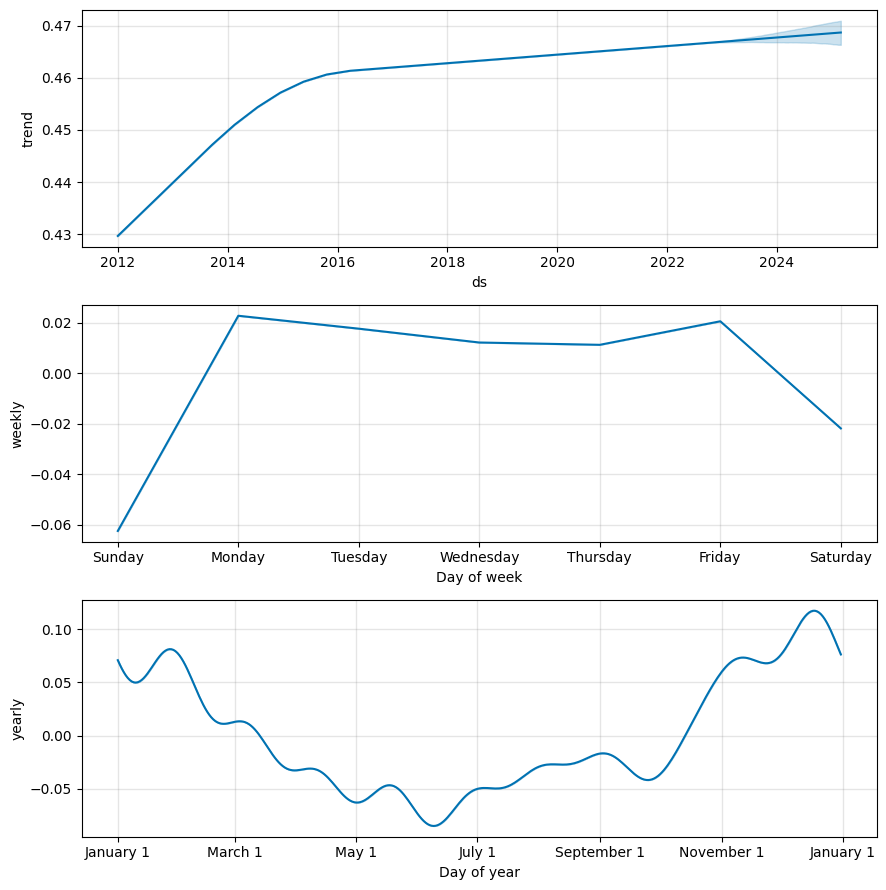

In [ ]:
prophet_df = train.reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires these specific column names

# Fit Prophet model on training data
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True,
                        daily_seasonality=False, changepoint_prior_scale=0.01,
                        changepoint_range=1.0)
model_prophet.fit(prophet_df)

top_n = 3
top_cp = changpoints.sort_values(by='deltas', ascending=False).head(top_n)['cp']

# Forecast for a number of periods equal to the length of the test set
future_dates = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future_dates)

# Calculate metrics for both models
prophet_fitted = forecast_prophet.loc[forecast_prophet['ds'].isin(prophet_df['ds']), 'yhat']
prophet_actual = prophet_df['y']


prophet_metrics = {
    'RMSE': np.sqrt(mean_squared_error(prophet_actual, prophet_fitted)),
    'MAE': mean_absolute_error(prophet_actual, prophet_fitted)
}

# Plot Prophet forecast and components
fig1 = model_prophet.plot(forecast_prophet)
for cp in top_cp:
    plt.axvline(x=cp, color='r', linestyle='--')
plt.title('CO Levels Forecast with Prophet')
plt.show()

fig2 = model_prophet.plot_components(forecast_prophet)
plt.show()

In [ ]:
# apply cross validation for the daily data
#  Define a Range of changepoint_prior_scale Values to Compare
cps_values = [0.001, 0.01, 0.05, 0.1, 0.5]

# Collect performance metrics for each CPS value
all_perf = []

for cps in cps_values:
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        changepoint_range=1.0
    )
    model.fit(prophet_df)

    # Cross-Validation Setup
    df_cv = cross_validation(
        model=model,
        initial='1460 days',  # ~4 years
        period='180 days',    # ~6 months
        horizon='365 days',   # ~1 year forecast
        parallel='processes'  # speeds up CV if you have multiple CPUs
    )

   # Compute Performance Metrics
    df_perf = performance_metrics(df_cv)
    df_perf['changepoint_prior_scale'] = cps

    all_perf.append(df_perf)

INFO:prophet:Making 12 forecasts with cutoffs between 2016-02-10 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df59dd26e90>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-02-10 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df59dcb94d0>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-02-10 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df59dd90d10>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-02-10 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7df59e7d9510>
INFO:prophet:Making 12 forecasts with cutoffs between 2016-02-10 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures

In [ ]:
results_df.groupby('changepoint_prior_scale', as_index=False).mean()

,changepoint_prior_scale,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0.001,203 days 17:05:27.272727272,0.009403,0.096395,0.076131,0.180586,0.139311,0.163809,0.667118
1,0.010,203 days 17:05:27.272727272,0.008318,0.090788,0.072559,0.168941,0.132665,0.158207,0.677399
2,0.050,203 days 17:05:27.272727272,0.010913,0.103789,0.081709,0.185119,0.149562,0.183438,0.609488
3,0.100,203 days 17:05:27.272727272,0.012490,0.110912,0.086100,0.191803,0.162470,0.196457,0.579275
4,0.500,203 days 17:05:27.272727272,0.021009,0.142422,0.108296,0.237027,0.201076,0.259295,0.486201
